In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics.pairwise import euclidean_distances
#from sklearn.neighbors import KDTree
from scipy import spatial
from mpl_toolkits import mplot3d

In [2]:
class PointCloudVarifold:
    
    def __init__(self, Ntot=10, d=2, n=3):
        self.varifoldDim = d
        self.ambientDim = n
        self.size = Ntot
        
    def loadFromArray(self, X):
        Ntot, n = X.shape
        d = self.varifoldDim
        self.size = Ntot
        self.ambientDim = n
        self.pts = X
        self.mass = np.ones(Ntot)
        self.tgtProj = np.zeros((Ntot, n, n))
        self.tgtBasis = np.zeros((Ntot, n, d))
        self.normal = np.zeros((Ntot, n))
        self.curvature = np.zeros((Ntot, n))
        
    def computeKDTree(self):
        self.tree = spatial.KDTree(X)
    
    def regressionKnn(self, kT, kernel, massWeights = True, truncateToProjector = True):
        X = self.pts
        Ntot = self.size
        n = self.ambientDim
        if massWeights:
            m = self.mass
        else:
            m = np.ones(Ntot)
        tree = self.tree     
        for i in range(Ntot):
            x = X[i, :]
            dist, ind = tree.query(x, kT)
            r = dist[-1] # radius of the ball containing points
            M = 0
            for j in range(kT):
                z = X[i, :] - X[ind[j], :]
                M = M + m[ind[j]]*kernel(np.linalg.norm(z)/r)*np.outer(z,z)
            if truncateToProjector: # assume codimension 1
                w, v = np.linalg.eigh(M)
                self.tgtProj[i] = np.identity(n) - np.outer(v[:,0],v[:,0])
                self.normal[i] = v[:,0]
                self.tgtBasis[i] = v[:,1:3]
            else:
                self.tgtProj[i] = M/kT
            if i%10000 == 0:
                print(str(i)+'-')
                
    def computeMassKnn(self, kM, kernelOpt = False):
        X = self.pts
        Ntot = self.size
        d = self.varifoldDim
        tree = self.tree 
        for i in range(Ntot):
            x = X[i, :]
            dist, ind = tree.query(x, kM)
            r = dist[-1] # radius of the ball containing points
            self.mass[i] = r**d/kM # up to dimensional constant d-volume of unit ball

            if True:
                self.mass[i] = 1
            
    def regressionRadius(self, r, kernel, massWeights = True):
        X = self.pts
        Ntot = self.size
        if massWeights:
            m = self.mass
        else:
            m = np.ones(Ntot)
        tree = self.tree
        for i in range(Ntot):
            x = X[i, :]
            ind = tree.query_ball_point(x, r)
            k = len(ind)
            M = 0
            for j in range(k): 
                z = X[i, :] - X[ind[j], :]
                M = M + m[ind[j]]*kernel(np.linalg.norm(z)/r)*np.outer(z,z)
            self.tgtProj[i] = M/k

    def computeSFFKnn(self, kT, kernelPrime, kernelXi):
        X = self.pts
        Ntot = self.size
        n = self.ambientDim
        #self.varifoldDim = n-1 # codim 1
        d = n-1
        self.sff = np.zeros((Ntot,d,d))
        self.gaussCurvature = np.zeros(Ntot)
        self.meanCurvature = np.zeros((Ntot,n))
        tree = self.tree  
        Bijk = np.zeros((n,n,n))
        for i in range(Ntot):
            x0 = X[i, :]
            T0 = self.tgtProj[i]
            dist, ind = tree.query(x0, kT)
            eps = dist[-1] # radius of the ball containing points
            Bijk = np.zeros((n,n,n))
            Bij = np.zeros((n,n))
            denom = 0
            for jneigh in range(1,kT):
                z = x0 - X[ind[jneigh], :]
                deltaZ = dist[jneigh]
                znormalized = z/ deltaZ
                w = self.varifoldDim*kernelPrime(deltaZ/eps) # multp by mass m_j
                denom += kernelXi(deltaZ/eps) # multp by mass m_j, Xi(0) = 0 for pairs otherwise add j=0
                T = self.tgtProj[ind[jneigh]]
                deltaT = T - T0

                if False:
                    for ii in range(n):
                        for jj in range(n):
                            for kk in range(n):
                                Bijk[ii,jj,kk] += w*np.vdot(znormalized, 0.5*(deltaT[jj,kk]*T[:,ii] + deltaT[ii,kk]*T[:,jj] - deltaT[ii,jj]*T[:,kk] ))
                            Bij[ii,jj] = np.dot(Bijk[ii,jj,:], self.normal[i])
                elif False:
                    q = T.dot(znormalized)
                    n_i = self.normal[i]
                    dTn = deltaT.dot(n_i)
                    Bij += 0.5 * w * (np.outer(q, dTn) + np.outer(dTn, q) - np.dot(q, n_i) * deltaT)
                elif False:
                    q = T.dot(znormalized)
                    n_i = self.normal[i]
                    n_j = self.normal[ind[jneigh]]
                    dTn = n_i - n_j * np.dot(n_i, n_j)
                    Bij += 0.5 * w * (np.outer(q, dTn) + np.outer(dTn, q) - np.dot(q, n_i) * deltaT)
                elif False:
                    q = T.dot(znormalized)
                    n_i = self.normal[i]
                    n_j = self.normal[ind[jneigh]]
                    dTn = n_i - n_j * np.dot(n_i, n_j)
                    Bij += 0.5 * w * (np.outer(q, dTn) + np.outer(dTn, q) - np.dot(q, n_i) * deltaT)
                elif False:
                    q = T.dot(znormalized)
                    n_i = self.normal[i]
                    n_j = self.normal[ind[jneigh]]
                    dTn = - n_j * np.dot(n_i, n_j)
                    Bij += 0.5 * w * (np.outer(q, dTn) + np.outer(dTn, q) - np.dot(q, n_i) * deltaT)
                elif False:
                    q = T.dot(znormalized)
                    n_i = self.normal[i]
                    n_j = self.normal[ind[jneigh]]
                    Bij += 0.5 * w * (np.dot(n_i, n_j) * (np.outer(q, n_j) + np.outer(n_j, q)) + np.dot(q, n_i) * np.outer(n_j, n_j))
                elif True:
                    q = T.dot(znormalized)
                    n_i = self.normal[i]
                    n_j = self.normal[ind[jneigh]]
                    Bij += 0.5 * w * np.outer(n_j, 2 * np.dot(n_i, n_j) * q + np.dot(q, n_i) * n_j)
                else:
                    n_i = self.normal[i]
                    n_j = self.normal[ind[jneigh]]
                    ww = 0.5 * w * np.vdot(znormalized, n_i - np.dot(n_i, n_j)*n_j)
                    Bij += ww*np.outer(n_j, n_j)

            Bij /= eps*denom
            self.sff[i] = np.transpose(self.tgtBasis[i]).dot(Bij.dot(self.tgtBasis[i]))
            self.gaussCurvature[i] = np.linalg.det(self.sff[i])
            self.meanCurvature[i] = .5 * np.trace(self.sff[i])*self.normal[i]
                
                
                
"""    
# small test : first execute the cell containing kernel definitions
V = PointCloudVarifold()
X = np.random.rand(10,3)
V.loadFromArray(X)
V.computeKDTree()
V.computeMass(5)
V.regressionKnn(4, standard)
V.computeSFFKnn(7, standardPrime, standardPair)
V.gaussCurvature
"""

'    \n# small test : first execute the cell containing kernel definitions\nV = PointCloudVarifold()\nX = np.random.rand(10,3)\nV.loadFromArray(X)\nV.computeKDTree()\nV.computeMass(5)\nV.regressionKnn(4, standard)\nV.computeSFFKnn(7, standardPrime, standardPair)\nV.gaussCurvature\n'

In [3]:
"""
n # ambient dimension
d # varifold dimension

kC # number of neighbours for curvature computation 
kT # number of neighbours for tangent computation
kM # number of neighbours for mass computation
"""

'\nn # ambient dimension\nd # varifold dimension\n\nkC # number of neighbours for curvature computation \nkT # number of neighbours for tangent computation\nkM # number of neighbours for mass computation\n'

# 1. Creating a point cloud

## Loading point cloud from a .txt file

In [4]:
import trimesh 
# Example
V = PointCloudVarifold()
#X = np.loadtxt('bunny.txt', skiprows=0, usecols=(0,1,2), max_rows=1000000)

X = trimesh.creation.icosphere(radius = 2, subdivisions=4).vertices

V.loadFromArray(X)


## Generating a point cloud

In [5]:
# Example : ellipsoid of revolution

def generateEllipsoid(a, b, Nloc):
    # Nloc : number of points on the main horizontal circle of length 2*a*np.pi
   
    # Computation of total number of points Ntot
    Ntot = 0
    p = np.sqrt(2*(a**2 + b**2)) # p*np.pi ~ perimeter of a vertical ellipse
    Nvert = int(0.25*Nloc*p/a) # number of points on a half vertical ellipse
    hvert = np.pi/Nvert
    phi = 0
    for i in range(Nvert-1):
        phi += hvert
        Nphi = int(Nloc*np.sin(phi)) # number of points on a horizontal circle of radius a*sin(theta) at z = b*cos(theta)
        for j in range(Nphi):
            Ntot += 1
    # Initialisation
    n = 3
    X = np.zeros((Ntot,n))
    # Parametrization
    ind = 0
    phi = 0
    for i in range(Nvert-1):
        phi += hvert
        Nphi = int(Nloc*np.sin(phi)) # number of points on a horizontal circle of radius a*sin(theta) at z = b*cos(theta)
        print(Nphi)
        hhor = 2*np.pi/Nphi
        theta = 0
        for j in range(Nphi):
            theta += hhor
            X[ind,0] = a*np.sin(phi)*np.cos(theta)
            X[ind,1] = a*np.sin(phi)*np.sin(theta)
            X[ind,2] = b*np.cos(phi)
            ind += 1
    return X

"""
V = PointCloudVarifold()
X = generateEllipsoid(2, 2, 100)
V.loadFromArray(X)
"""

'\nV = PointCloudVarifold()\nX = generateEllipsoid(2, 2, 100)\nV.loadFromArray(X)\n'

# 2. Kernel definitions

We define several kernel profiles. The *standard* kernel, of derivative *standardPrime*, corresponds to
$$
\rho(t) = \exp \left(\frac{-1}{1-t^2}\right) \quad \text{et} \quad \rho^\prime(t) = \frac{-2t}{(1-t^2)^2} \exp \left(\frac{-1}{1-t^2}\right) \: .
$$

To each kernel $\rho$, we associate its *kernelPair* $\xi$ satisfying $n \xi(t) = - t \rho^\prime(t)$. For instance, the *standardPair* kernel is
$$
\xi(t) = \frac{2}{n} \frac{t^2}{(1-t^2)^2} \exp \left(\frac{-1}{1-t^2}\right) \: .
$$

In [6]:
my_kernel = "gaussian"

if my_kernel == "standard":
    def standard(x):
        y = (x<1)*x
        return (x<1)*np.exp(-1./(1-y**2))

    def standardPrime(x):
        y = (x<1)*x
        return (x<1)*(-2*y)/(1-y**2)**2*np.exp(-1./(1-y**2))

    def standardPair(x): # it remains to divide by n when used with its pair standardPrime or adjust constant in computSFFKnn
        y = (x<1)*x
        return (x<1)*(2)*y**2/(1-y**2)**2*np.exp(-1./(1-y**2))

    def constant(x):
        return (x<1)*1

elif my_kernel == "gaussian":
    def standard(x):
        return np.exp(-x**2 / 2)

    def standardPrime(x):
        return -x*np.exp(-x**2 / 2)

    def standardPair(x):
        return x**2*np.exp(-x**2 / 2)

    def constant(x):
        return 1

# Kernels, uncomment to see
#t = np.linspace(0,2,200)
#plt.plot(t,standard(t), label = 'rho')
#plt.plot(t,standardPrime(t), label = 'rhoPrime')
#plt.plot(t,standardPair(t), label = 'rhoPair')
#plt.legend()

# 3. Mass computation

*The method `computeMassKnn` attributes relative weights $m_i$ for $i = 1 \ldots N$ in order to rectify potential bias in the sampling: masses should be small in areas where points are concentrated.*

More precisely, we assume that the given set of points $\{ x_i \}_i$ is close to some surface (and more generally $d$-submanifold or $d$-rectifiable set) and we want to define masses $m_i$ for $i = 1 \ldots N$ so that the Radon measures $\displaystyle \mu_N = \sum_{i = 1}^N m_i \delta_{x_i}$ and $\mathcal{H}^d_{| M}$ are close, where $\mathcal{H}^d$ denotes the $d$-dimensional Hausdorff measure in $\mathbb{R}^n$. Let $\eta_r$ be a compactly supported radial kernel, i.e. given $\eta : \mathbb{R} \rightarrow \mathbb{R}_+$ even and compactly supported in $[-1,1]$, define for $r>0$ and $x \in \mathbb{R}^n$, $\eta_r(x) := \eta (|x|/r)$. A natural choice is then to consider

$$
m_i = C_\eta \frac{r^d}{\displaystyle \sum_{j=1}^N \eta \left(\frac{|x_i - x_j|}{r} \right)} = \frac{\displaystyle\mathcal{H}^d_{| T_{x_i} M} \ast \eta_r(x_i)}{\mu_N \ast \eta_r(x_i) } \simeq_{r \to 0} \frac{\displaystyle\mathcal{H}^d_{| M} \ast \eta_r(x_i)}{\mu_N \ast \eta_r(x_i) } 
$$
where $C_\eta > 0$ is the integral over any $d$-vector subspace $P \subset \mathbb{R}^n$ of $x \mapsto \eta(|x|)$ (since $\eta$ is radial):
$$
C_\eta = \int_P \eta (|x|) \: d \mathcal{H}^d(x) = d \omega_d \int_0^1 \eta(r) r^{d-1} \: dr \quad \text{and} \quad \omega_d \text{ is the Lebesgue measure of the unit ball of } \mathbb{R}^d \: .
$$
Constant $C_\eta$ can however be dropped when computing relative weights of points since it is uniform in the whole point cloud.

We can either choose the number $k_M$ of neighbours and infer the radius $r>0$ of the neighbouring ball to be considered (`Knn`) or choose the radius $r>0$ of the neighbouring ball (not implemented yet) and infer $k_M$.

**Up to now, we implemented the following expression:**
$$
m_i = \frac{r^d}{k_M}
$$
corresponding to $\eta = \chi_{[-1,1]}$ and thus $C_\eta = \omega_d$ has been dropped in the implementation (for $d = 2$, $\omega_d = \pi$ for instance).

In [7]:
V.computeKDTree()
V.computeMassKnn(10)

## Example of mass visualisation

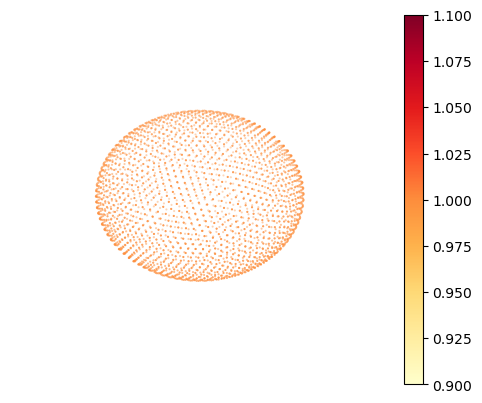

In [8]:
%matplotlib inline
ax = plt.axes(projection='3d')
ax.set_axis_off()
plt.set_cmap('YlOrRd')
pc = ax.scatter(V.pts[:,0], V.pts[:,1], V.pts[:,2], c = V.mass, zdir = 'x', s=0.3)
plt.colorbar(pc)
plt.show()

# 4. Regression

The method *regressionKnn* and *regressionRadius* perform a local covariance analysis, weighted with *kernel*, hereafter denoted by $\omega$, so as to define the tangent at each point of the point cloud varifold. We can either choose the number $k_T$ of neighbours and infer the radius $r>0$ of the neighbouring ball to be considered (*Knn*) or choose the radius $r >$ of the neighbouring ball (*Radius*) and infer $k_T$. Given a point $x_{i_0}$ in the cloud, we compute the matrix
$$
\frac{1}{k_T} \sum_{j = 1}^N m_j \omega \left( \frac{|x_j - x_{i_0} |}{r} \right) \underbrace{(x_j - x_{i_0})^T (x_j - x_{i_0})}_{n \times n \text{ rank } 1 \text{ matrix}} \: .
$$
While the sum is over the whole set of points, the kernel has support $r>0$ and the sum is over $k_T$ terms. Depending on the option *massWeights*, $m_j$ is the local mass stored in the attribute *mass* or all $m_j$ are set to $1$.


In [9]:
# Examples
#V = PointCloudVarifold()
#X = np.random.rand(100,3)
#V.loadFromArray(X)
#V.computeKDTree() # Useless if already computed for mass computation
V.regressionKnn(20, standard) # kT = 20, kernel omega = standard
#V.regressionRadius(0.1, standardPair) # r = 0.1, kernel omega = standardPair (no need to divide by constant 1/n)

0-


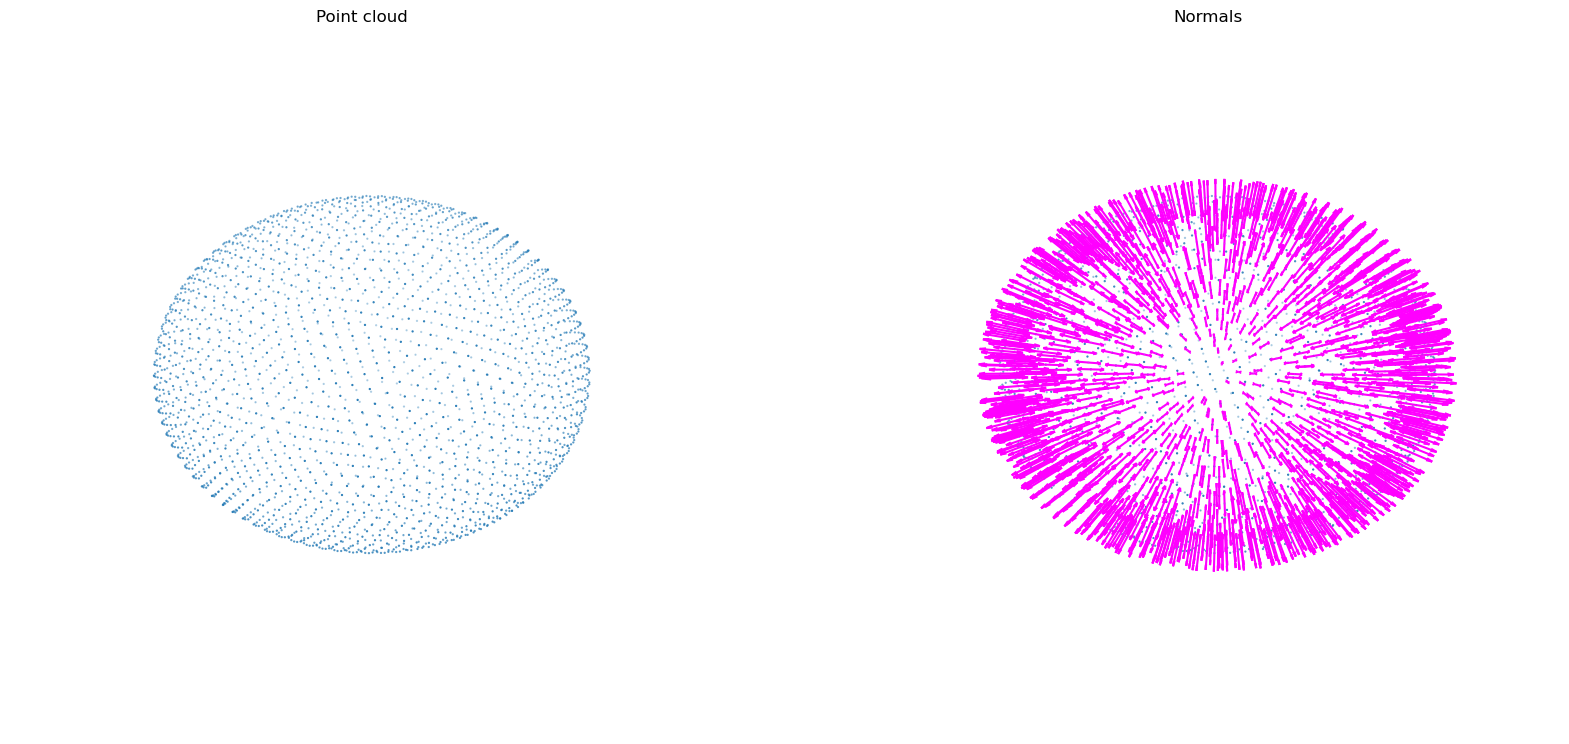

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_axis_off()
ax1.set_xlim([-2,2]); ax1.set_ylim([-2,2]); ax1.set_zlim([-2,2])
pc1 = ax1.scatter(V.pts[:,0], V.pts[:,1], V.pts[:,2], zdir = 'x', s = 0.4)
ax1.set_title('Point cloud')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_axis_off()
ax2.scatter(V.pts[:,0], V.pts[:,1], V.pts[:,2], zdir = 'x', s = 0.4)
sub = 2 # displays 1 out of sub normal
ax2.quiver(V.pts[::sub,2], V.pts[::sub,0], V.pts[::sub,1], V.normal[::sub,2], V.normal[::sub,0], V.normal[::sub,1], length=0.2, color = 'magenta')
ax2.quiver(V.pts[::sub,2], V.pts[::sub,0], V.pts[::sub,1], -V.normal[::sub,2], -V.normal[::sub,0], -V.normal[::sub,1], length=0.2, color = 'magenta')
ax2.set_title('Normals')
ax2.set_xlim([-2,2]); ax2.set_ylim([-2,2]); ax2.set_zlim([-2,2])
plt.show()

# 5. Computation of second fundamental form

In [11]:
# Example
#V = PointCloudVarifold()
#X = np.random.rand(100,3)
#V.loadFromArray(X)
#V.computeKDTree() # Useless if already computed for mass computation
#V.regressionKnn(20, standard) # kT = 20, kernel omega = standard 
V.computeSFFKnn(25, standardPrime, standardPair)

## Example of gaussian and mean curvature visualisation

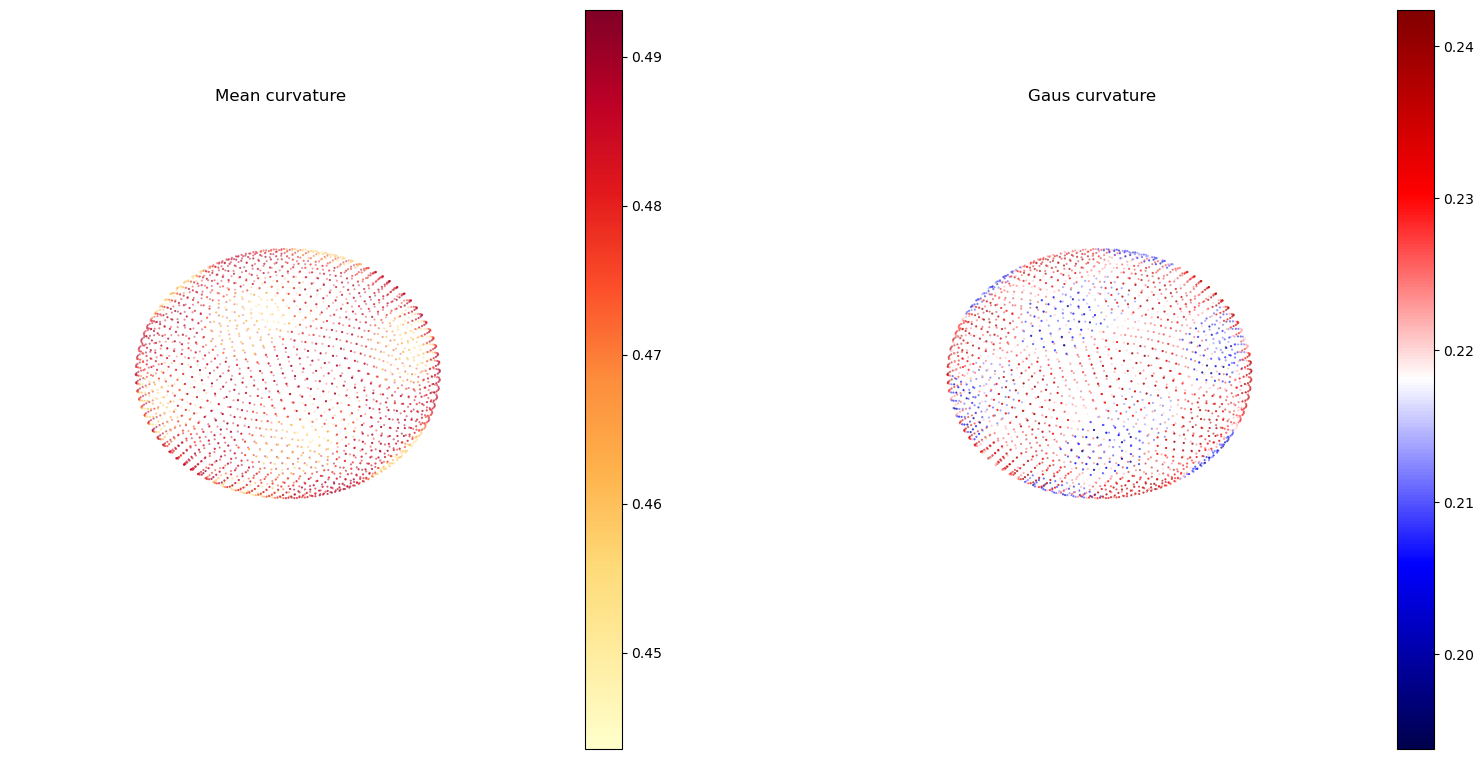

In [12]:
interactive = False
option = "gauss" # "mean" # Choose "gauss" for Gaussian curvature and "mean" for mean curvature


if interactive:
    %matplotlib notebook
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    if option == "gauss":
        plt.set_cmap('seismic')
        pc = ax.scatter(V.pts[:,0], V.pts[:,1], V.pts[:,2], c = V.gaussCurvature, zdir = 'x', s=0.3)
    else:
        plt.set_cmap('YlOrRd')
        pc = ax.scatter(V.pts[:,0], V.pts[:,1], V.pts[:,2], c = np.sqrt(V.meanCurvature[:,0]**2 + V.meanCurvature[:,1]**2 + V.meanCurvature[:,2]**2), zdir = 'x', s=0.3)
    plt.colorbar(pc)
    plt.show()
else:
    %matplotlib inline
    #fig = plt.figure(figsize=(40,15))
    fig = plt.figure(figsize=plt.figaspect(0.5)*2)
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_axis_off()
    #ax1.set_xlim([-4,4]); ax1.set_ylim([-4,4]); ax1.set_zlim([0,8]); 
    pc1 = ax1.scatter(V.pts[:,0], V.pts[:,1], V.pts[:,2], zdir = 'x', c = np.sqrt(V.meanCurvature[:,0]**2 + V.meanCurvature[:,1]**2 + V.meanCurvature[:,2]**2), s=0.3)
    fig.colorbar(pc1)
    ax1.set_title('Mean curvature')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_axis_off()
    pc2 = ax2.scatter(V.pts[:,0], V.pts[:,1], V.pts[:,2], zdir = 'x', c = V.gaussCurvature, cmap = 'seismic', s=0.3)
    fig.colorbar(pc2)
    ax2.set_title('Gaus curvature')
    plt.show()

In [13]:
"""
# Kernel choice for curvature, default is smooth and compactly supported
rho = standard
rhoPrime = standardPrime
xi = standardPair
# Kernel choice for regression, default is smooth and compactly supported
omega = standard
# Kernel for mass
eta = constant 
"""

'\n# Kernel choice for curvature, default is smooth and compactly supported\nrho = standard\nrhoPrime = standardPrime\nxi = standardPair\n# Kernel choice for regression, default is smooth and compactly supported\nomega = standard\n# Kernel for mass\neta = constant \n'